In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
station = pd.read_csv('station_data.csv')
trip = pd.read_csv('trip_data.csv')
weather = pd.read_csv('weather_data.csv')
zip2city = pd.read_csv('us_postal_codes.csv')

## Data Exploration

In [19]:
station.head(), len(station)

(          Id                               Name        Lat        Long  \
 City                                                                     
 San Jose   2  San Jose Diridon Caltrain Station  37.329732 -121.901782   
 San Jose   3              San Jose Civic Center  37.330698 -121.888979   
 San Jose   4             Santa Clara at Almaden  37.333988 -121.894902   
 San Jose   5                   Adobe on Almaden  37.331415 -121.893200   
 San Jose   6                   San Pedro Square  37.336721 -121.894074   
 
           Dock Count  
 City                  
 San Jose          27  
 San Jose          15  
 San Jose          11  
 San Jose          19  
 San Jose          15  , 76)

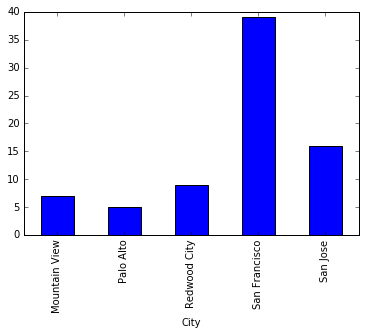

In [5]:
station.groupby('City').count()['Id'].plot.bar()

In [6]:
station = station.set_index('City')

In [7]:
station.head()

,Id,Name,Lat,Long,Dock Count
City,,,,,
San Jose,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27
San Jose,3,San Jose Civic Center,37.330698,-121.888979,15
San Jose,4,Santa Clara at Almaden,37.333988,-121.894902,11
San Jose,5,Adobe on Almaden,37.331415,-121.893200,19
San Jose,6,San Pedro Square,37.336721,-121.894074,15


In [8]:
trip.head()

,Trip ID,Start Date,Start Station,End Date,End Station,Subscriber Type
0,913460,31/08/2015 23:26,50,31/08/2015 23:39,70,Subscriber
1,913459,31/08/2015 23:11,31,31/08/2015 23:28,27,Subscriber
2,913455,31/08/2015 23:13,47,31/08/2015 23:18,64,Subscriber
3,913454,31/08/2015 23:10,10,31/08/2015 23:17,8,Subscriber
4,913453,31/08/2015 23:09,51,31/08/2015 23:22,60,Customer


In [9]:
trip['Start Day'] = trip['Start Date'].apply(lambda x: x[0:10])
trip['End Day'] = trip['End Date'].apply(lambda x: x[0:10])
trip['Start hour'] = trip['Start Date'].apply(lambda x: int(x[-5:-3]))
trip['End hour'] = trip['End Date'].apply(lambda x: int(x[-5:-3]))

In [10]:
trip.head()

,Trip ID,Start Date,Start Station,End Date,End Station,Subscriber Type,Start Day,End Day,Start hour,End hour
0,913460,31/08/2015 23:26,50,31/08/2015 23:39,70,Subscriber,31/08/2015,31/08/2015,23,23
1,913459,31/08/2015 23:11,31,31/08/2015 23:28,27,Subscriber,31/08/2015,31/08/2015,23,23
2,913455,31/08/2015 23:13,47,31/08/2015 23:18,64,Subscriber,31/08/2015,31/08/2015,23,23
3,913454,31/08/2015 23:10,10,31/08/2015 23:17,8,Subscriber,31/08/2015,31/08/2015,23,23
4,913453,31/08/2015 23:09,51,31/08/2015 23:22,60,Customer,31/08/2015,31/08/2015,23,23


In [11]:
station_start = trip.groupby(['Start Station','Start Day', 'Start hour']).count()[['Trip ID']]
station_end = trip.groupby(['End Station', 'End Day', 'End hour']).count()[['Trip ID']]

In [12]:
station_start.reset_index(level=[0, 1, 2], inplace=True)
station_start = station_start.rename(columns={'Start Station': 'Station', 'Start Day': 'Day', 'Start hour':'Hour'})

station_end.reset_index(level=[0, 1, 2], inplace=True)
station_end = station_end.rename(columns={'End Station': 'Station', 'End Day': 'Day', 'End hour':'Hour'})


In [13]:
trip_count = pd.merge(station_start, station_end, left_on=['Station','Day', 'Hour'], right_on = ['Station','Day', 'Hour'], suffixes=('_start', '_end'))

In [14]:
trip_count.describe()

,Station,Hour,Trip ID_start,Trip ID_end
count,83024.000000,83024.000000,83024.000000,83024.000000
mean,59.472225,13.309814,3.072076,3.167650
std,17.341354,4.383110,3.314590,3.664037
min,2.000000,0.000000,1.000000,1.000000
25%,50.000000,9.000000,1.000000,1.000000
50%,62.000000,13.000000,2.000000,2.000000
75%,71.000000,17.000000,4.000000,4.000000
max,90.000000,23.000000,52.000000,56.000000


In [15]:
trip_count.head()

,Station,Day,Hour,Trip ID_start,Trip ID_end
0,2,01/01/2015,13,1,1
1,2,01/04/2015,6,1,5
2,2,01/04/2015,7,2,5
3,2,01/04/2015,17,4,3
4,2,01/04/2015,18,3,1


In [16]:
trip_count['Net Rate'] = trip_count['Trip ID_end'] - trip_count['Trip ID_start']

In [17]:
trip_count.head()

,Station,Day,Hour,Trip ID_start,Trip ID_end,Net Rate
0,2,01/01/2015,13,1,1,0
1,2,01/04/2015,6,1,5,4
2,2,01/04/2015,7,2,5,3
3,2,01/04/2015,17,4,3,-1
4,2,01/04/2015,18,3,1,-2


In [18]:
trip_count.groupby(['Station', 'Hour']).describe().T

Station          2                                               ...    90  \
Hour             0                                       1       ...    22   
              count mean std  min  25%  50%  75%  max count mean ...   75%   
Net Rate        1.0  0.0 NaN  0.0  0.0  0.0  0.0  0.0   1.0  0.0 ...   0.0   
Trip ID_end     1.0  1.0 NaN  1.0  1.0  1.0  1.0  1.0   1.0  1.0 ...   1.0   
Trip ID_start   1.0  1.0 NaN  1.0  1.0  1.0  1.0  1.0   1.0  1.0 ...   1.0   

Station                                                      
Hour                  23                                     
               max count mean  std  min  25%  50%  75%  max  
Net Rate       2.0   2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
Trip ID_end    3.0   2.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  
Trip ID_start  1.0   2.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  

[3 rows x 11040 columns]

In [20]:
#Ignoring the day
mean_rate = trip_count.groupby(['Station', 'Hour']).mean()[['Net Rate']]

In [21]:
mean_rate.reset_index(level=[1], inplace=True)

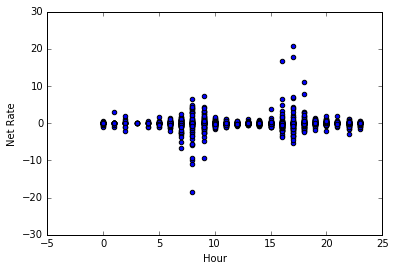

In [22]:
#difference introduced by station and day
mean_rate.plot.scatter('Hour','Net Rate')

In [23]:
weather = weather.set_index('Zip')

In [24]:
len(weather)

1825

In [25]:
weather.columns

Index([u'Date', u'Max TemperatureF', u'Mean TemperatureF', u'Min TemperatureF',
       u'Max Dew PointF', u'MeanDew PointF', u'Min DewpointF', u'Max Humidity',
       u'Mean Humidity', u'Min Humidity', u'Max Sea Level PressureIn',
       u'Mean Sea Level PressureIn', u'Min Sea Level PressureIn',
       u'Max VisibilityMiles', u'Mean VisibilityMiles', u'Min VisibilityMiles',
       u'Max Wind SpeedMPH', u'Mean Wind SpeedMPH', u'Max Gust SpeedMPH',
       u'PrecipitationIn', u'CloudCover', u'Events', u'WindDirDegrees'],
      dtype='object')

In [26]:
zip2city.head()

,Zip Code,Place Name,State,State Abbreviation,County,Latitude,Longitude
0,501,Holtsville,New York,NY,Suffolk,40.8154,-73.0451
1,544,Holtsville,New York,NY,Suffolk,40.8154,-73.0451
2,1001,Agawam,Massachusetts,MA,Hampden,42.0702,-72.6227
3,1002,Amherst,Massachusetts,MA,Hampshire,42.3671,-72.4646
4,1003,Amherst,Massachusetts,MA,Hampshire,42.3919,-72.5248


In [27]:
zip2city = zip2city.rename(index=int, columns={"Zip Code": "Zip"})

In [28]:
zip2city = zip2city.set_index('Zip')

In [29]:
weather_zip = weather.join(zip2city, how='left' )

In [30]:
weather_zip.head()

,Date,Max TemperatureF,Mean TemperatureF,Min TemperatureF,Max Dew PointF,MeanDew PointF,Min DewpointF,Max Humidity,Mean Humidity,Min Humidity,...,PrecipitationIn,CloudCover,Events,WindDirDegrees,Place Name,State,State Abbreviation,County,Latitude,Longitude
Zip,,,,,,,,,,,,,,,,,,,,,
94041,01/09/2014,85.0,73.0,60.0,60.0,58.0,53.0,84.0,59.0,34.0,...,0.0,0.0,NaN,342.0,Mountain View,California,CA,Santa Clara,37.3893,-122.0783
94041,02/09/2014,76.0,69.0,61.0,60.0,59.0,57.0,84.0,73.0,61.0,...,0.0,2.0,NaN,359.0,Mountain View,California,CA,Santa Clara,37.3893,-122.0783
94041,03/09/2014,79.0,70.0,61.0,60.0,57.0,54.0,84.0,66.0,48.0,...,0.0,3.0,NaN,33.0,Mountain View,California,CA,Santa Clara,37.3893,-122.0783
94041,04/09/2014,78.0,70.0,62.0,60.0,58.0,56.0,84.0,67.0,50.0,...,0.0,4.0,NaN,25.0,Mountain View,California,CA,Santa Clara,37.3893,-122.0783
94041,05/09/2014,76.0,69.0,61.0,59.0,57.0,55.0,84.0,69.0,54.0,...,0.0,4.0,NaN,34.0,Mountain View,California,CA,Santa Clara,37.3893,-122.0783


In [31]:
weather_zip.columns

Index([u'Date', u'Max TemperatureF', u'Mean TemperatureF', u'Min TemperatureF',
       u'Max Dew PointF', u'MeanDew PointF', u'Min DewpointF', u'Max Humidity',
       u'Mean Humidity', u'Min Humidity', u'Max Sea Level PressureIn',
       u'Mean Sea Level PressureIn', u'Min Sea Level PressureIn',
       u'Max VisibilityMiles', u'Mean VisibilityMiles', u'Min VisibilityMiles',
       u'Max Wind SpeedMPH', u'Mean Wind SpeedMPH', u'Max Gust SpeedMPH',
       u'PrecipitationIn', u'CloudCover', u'Events', u'WindDirDegrees',
       u'Place Name', u'State', u'State Abbreviation', u'County', u'Latitude',
       u'Longitude'],
      dtype='object')

In [32]:
len(weather_zip)==len(weather)

True

In [33]:
weather_zip = weather_zip.set_index('Place Name')

In [34]:
station_weather = station.join(weather_zip, how='left')

In [35]:
station_weather.reset_index(level=[0], inplace=True)

In [36]:
station_weather = station_weather.rename(columns={'index': 'City'})

In [37]:
df = pd.merge(trip_count, station_weather, left_on=['Station','Day'], right_on = ['Id','Date'])

In [38]:
df.columns

Index([u'Station', u'Day', u'Hour', u'Trip ID_start', u'Trip ID_end',
       u'Net Rate', u'City', u'Id', u'Name', u'Lat', u'Long', u'Dock Count',
       u'Date', u'Max TemperatureF', u'Mean TemperatureF', u'Min TemperatureF',
       u'Max Dew PointF', u'MeanDew PointF', u'Min DewpointF', u'Max Humidity',
       u'Mean Humidity', u'Min Humidity', u'Max Sea Level PressureIn',
       u'Mean Sea Level PressureIn', u'Min Sea Level PressureIn',
       u'Max VisibilityMiles', u'Mean VisibilityMiles', u'Min VisibilityMiles',
       u'Max Wind SpeedMPH', u'Mean Wind SpeedMPH', u'Max Gust SpeedMPH',
       u'PrecipitationIn', u'CloudCover', u'Events', u'WindDirDegrees',
       u'State', u'State Abbreviation', u'County', u'Latitude', u'Longitude'],
      dtype='object')

In [49]:
def plot_correlation_matrix(df):
    """Takes a pandas dataframe as input"""
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
    
    cax = ax.matshow(df.corr())

    ticks = list(range(len(df.columns)))
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)

    ax.set_xticklabels(df.columns, rotation=20, horizontalalignment='left')
    ax.set_yticklabels(df.columns)

    plt.tight_layout()
    plt.show()

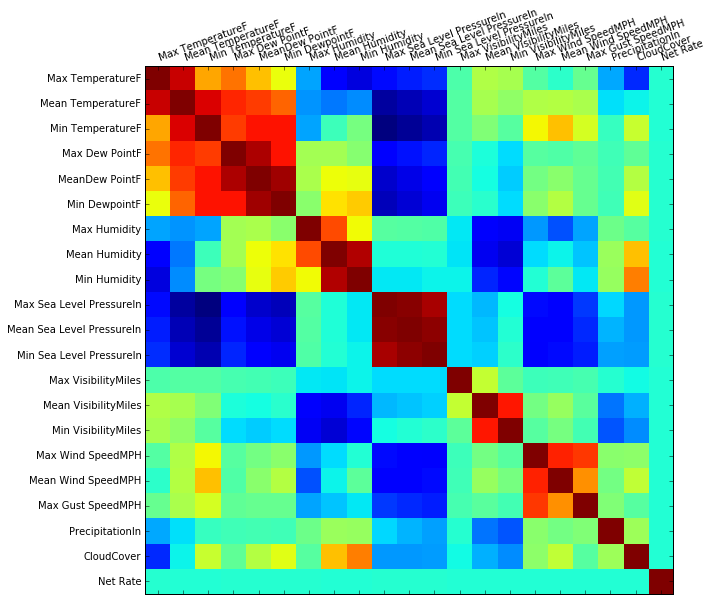

In [50]:
plot_correlation_matrix(df[[u'Max TemperatureF', u'Mean TemperatureF', u'Min TemperatureF',
       u'Max Dew PointF', u'MeanDew PointF', u'Min DewpointF', u'Max Humidity',
       u'Mean Humidity', u'Min Humidity', u'Max Sea Level PressureIn',
       u'Mean Sea Level PressureIn', u'Min Sea Level PressureIn',
       u'Max VisibilityMiles', u'Mean VisibilityMiles', u'Min VisibilityMiles',
       u'Max Wind SpeedMPH', u'Mean Wind SpeedMPH', u'Max Gust SpeedMPH',
       u'PrecipitationIn', u'CloudCover', 'Net Rate']])

In [41]:
df.head()

,Station,Day,Hour,Trip ID_start,Trip ID_end,Net Rate,City,Id,Name,Lat,...,Max Gust SpeedMPH,PrecipitationIn,CloudCover,Events,WindDirDegrees,State,State Abbreviation,County,Latitude,Longitude
0,2,01/01/2015,13,1,1,0,San Jose,2,San Jose Diridon Caltrain Station,37.329732,...,10.0,0.0,0.0,NaN,129.0,California,CA,Santa Clara,37.3329,-121.8916
1,2,01/04/2015,6,1,5,4,San Jose,2,San Jose Diridon Caltrain Station,37.329732,...,28.0,0.0,2.0,NaN,302.0,California,CA,Santa Clara,37.3329,-121.8916
2,2,01/04/2015,7,2,5,3,San Jose,2,San Jose Diridon Caltrain Station,37.329732,...,28.0,0.0,2.0,NaN,302.0,California,CA,Santa Clara,37.3329,-121.8916
3,2,01/04/2015,17,4,3,-1,San Jose,2,San Jose Diridon Caltrain Station,37.329732,...,28.0,0.0,2.0,NaN,302.0,California,CA,Santa Clara,37.3329,-121.8916
4,2,01/04/2015,18,3,1,-2,San Jose,2,San Jose Diridon Caltrain Station,37.329732,...,28.0,0.0,2.0,NaN,302.0,California,CA,Santa Clara,37.3329,-121.8916


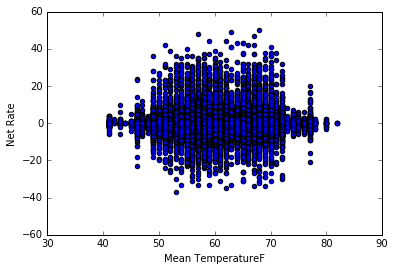

In [42]:
df.plot.scatter('Mean TemperatureF','Net Rate')

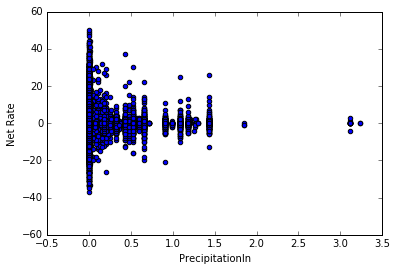

In [43]:
df.plot.scatter('PrecipitationIn','Net Rate')

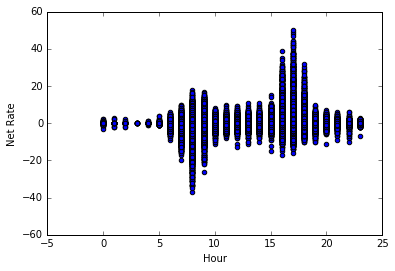

In [44]:
df.plot.scatter('Hour','Net Rate')

## Modelling approach

In [51]:
df['Events'] = df['Events'].fillna('None')
df = df.dropna()

In [52]:
features = ['Hour', 'Name', 'Events', 'City']

In [53]:
num_fea = ['Dock Count', 'Mean TemperatureF', 'PrecipitationIn', 'Mean Wind SpeedMPH', 
           'Mean VisibilityMiles', 'MeanDew PointF', 'Mean Sea Level PressureIn']

In [54]:
X_cat = pd.get_dummies(df[features])
X = pd.concat([X_cat, df[num_fea]], axis=1)

y = df['Net Rate']

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

print("Training length: " +str(len(y_train)))
print("Test length: " +str(len(y_test)))

Training length: 60503
Test length: 20168


In [56]:
regr = RandomForestRegressor(n_estimators=200, min_samples_leaf=10, random_state=0, n_jobs=-1, oob_score=True, verbose=True)

In [57]:
%time
regr.fit(X_train, y_train)

CPU times: user 4 µs, sys: 3 µs, total: 7 µs
Wall time: 10 µs


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.1min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=True, random_state=0, verbose=True, warm_start=False)

## Performance Analysis

In [58]:
regr.score(X_train, y_train)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.1s finished


0.65769860645554468

In [59]:
regr.score(X_test, y_test)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


0.54411315524731196

In [60]:
y_train_hat = regr.predict(X_train)
y_test_hat = regr.predict(X_test)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


In [61]:
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_hat))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_hat))

In [62]:
rmse_train, rmse_test

(2.2135011942932357, 2.5763723360754542)

In [63]:
X_names = X_cat.columns.tolist()
X_names.extend(num_fea)

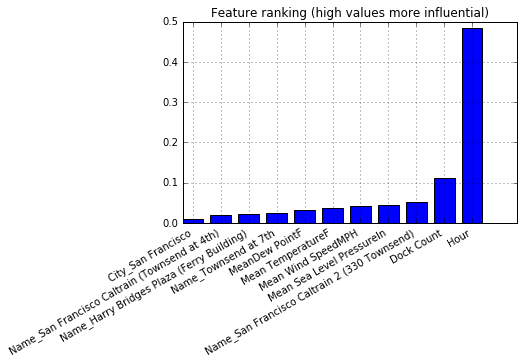

In [64]:
imp = regr.feature_importances_
sortNames = [y for (x,y) in sorted(zip(imp,X_names)) if x >0.01]
sortImp = [x for (x,y) in sorted(zip(imp,X_names)) if x >0.01]

fig = plt.figure()
ind = np.arange(len(sortImp))
width = .75
plt.bar(ind, sortImp, width=width)
plt.xticks(ind + width / 2, sortNames)
fig.autofmt_xdate()
plt.grid(True)
plt.title('Feature ranking (high values more influential)')
plt.show()